In [80]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from IPython import display

DATA_PATH = 'dataset/FMA/fma_small/'

In [85]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
# == Modified from 554X class example code ==
class Audio:
    def __init__(self, data, rate, fn):
        self.data = data
        self.rate = rate
        self.filename = fn.split("/")[-1]
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self, n_fft, hop_length):
        # n_fft = int(self.rate / 20)
        # hop_length = n_fft / 4
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft=n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=self.rate, hop_length=hop_length)
    def plot_melspectrum(self, n_fft, hop_length):
        D = librosa.power_to_db(librosa.feature.melspectrogram(self.data, sr=self.rate, n_fft=n_fft, hop_length=hop_length), ref=np.max)
        librosa.display.specshow(D, y_axis='mel', x_axis='time', sr=self.rate, hop_length=hop_length)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None), fn)

In [82]:
# Extract mp3 files from all directories under the data path
audio_paths = []
for root, directories, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if filename.endswith(".mp3"):
            audio_paths.append(os.path.join(root, filename))
print(np.shape(audio_paths))

(8000,)


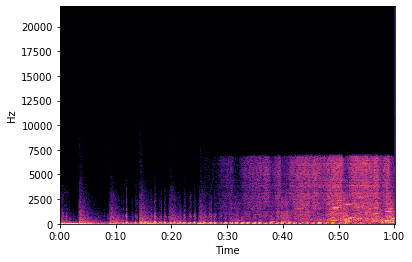

In [83]:
a0 = Audio.fromfile(audio_paths[0])
a0.plot_spectrum(2048, 1024)
a0.play()

In [ ]:
a0.plot_melspectrum(2048, 1024)